In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import glob
import imgaug.augmenters as iaa
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
archive_name = 'Nasa_Artemis.zip'
archive_path = '/content/drive/MyDrive/Nasa_Artemis.zip'

shutil.copy(archive_path, '.')

!7z x {archive_name}

data_path = '/content/Nasa_Artemis'
print('\nArchive extracted to VM\n')
print('-------------------------------------------------------------------------------------\n')
data_express_mode = True


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 151498006 bytes (145 MiB)

Extracting archive: Nasa_Artemis.zip
--
Path = Nasa_Artemis.zip
Type = zip
Physical Size = 151498006

  0%     17% 67 - Nasa_Artemis/Jessica_Meir/NASA Astronaut Jessica Meir - Seat of.png                                                                              35% 153 - Nasa_Artemis/Jessica_Meir/File_Jessica Meir portrait in a WB-57.jpg                                                                              

In [ ]:
data_path

'/content/Nasa_Artemis'

In [ ]:
all_image_urls = []
all_image_categories = []
for category in os.listdir(data_path):
  if category == '.DS_Store':
    continue
  category_path = os.path.join(data_path,category)
  for image_url in os.listdir(category_path):
    if image_url == '.DS_Store':
      continue
    all_image_urls.append(os.path.join(category_path,image_url))
    all_image_categories.append(category)


all_image_urls

['/content/Nasa_Artemis/Joseph_Acaba/Joseph M. Acaba on Twitter_ _Q_s about.jpg',
 '/content/Nasa_Artemis/Joseph_Acaba/Teacher hosts radio show in space.jpeg',
 '/content/Nasa_Artemis/Joseph_Acaba/Space_ NASA Astronaut Details Flight (1).jpg',
 '/content/Nasa_Artemis/Joseph_Acaba/Artemis astronaut feature_ Joe Acaba.jpg',
 '/content/Nasa_Artemis/Joseph_Acaba/Puerto Rican astronaut Joseph AcabaÌ\x81 (1).jpg',
 '/content/Nasa_Artemis/Joseph_Acaba/Joseph Acaba _ _ tucson.com.jpg',
 '/content/Nasa_Artemis/Joseph_Acaba/Astronaut Joseph Michael Acaba.jpg',
 '/content/Nasa_Artemis/Joseph_Acaba/Joseph Acaba.jpg',
 '/content/Nasa_Artemis/Joseph_Acaba/Puerto Rican astronaut Joseph AcabaÌ\x81 (3).jpg',
 '/content/Nasa_Artemis/Joseph_Acaba/Texas Tech.jpg',
 '/content/Nasa_Artemis/Joseph_Acaba/Joseph Acaba (4).jpg',
 '/content/Nasa_Artemis/Joseph_Acaba/File_ISS-31 Joseph Acaba with Robonaut.jpg',
 '/content/Nasa_Artemis/Joseph_Acaba/Joe Acaba (1).jpg',
 '/content/Nasa_Artemis/Joseph_Acaba/Joseph Ac

In [ ]:
from torchvision.transforms.transforms import RandomCrop
import torchvision.transforms as transforms
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from itertools import permutations


names = ["Jessica_Meir", "Joseph_Acaba", "Raja_Chari", "Scott_Tingle"]

mapping = {}
for x in range(len(names)):
  mapping[names[x]] = x


for x in range(len(all_image_categories)):
  all_image_categories[x] = mapping[all_image_categories[x]]


# Prepare augmentation transforms
n_transform = 4
n_aug = 12

augmentation_transforms = []
selectable_transforms = [transforms.ColorJitter(brightness=0.5), 
                         transforms.RandomRotation(degrees=(-45, 45), resample=False, expand=False), 
                         transforms.RandomHorizontalFlip(p=0.3),
                        #  transforms.RandomCrop(size=(170, 170), padding=None),
                         transforms.RandomVerticalFlip(p=0.3),
                          transforms.RandomGrayscale(p=0.4),
                          # transforms.Pad(0.2),
                          transforms.RandomPerspective(distortion_scale=0.5,p=0.5)]

intial_transforms = [transforms.ToPILImage(),transforms.Resize((224,224))]
final_transforms = [transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]

for i in range(n_aug):
  perm = list(np.random.permutation(len(selectable_transforms))[:n_transform])
  inner_random_transforms = [selectable_transforms[i] for i in perm]
  augmentation_transforms.append(transforms.Compose(intial_transforms + inner_random_transforms + final_transforms))

nonaugmentation_transforms = transforms.Compose(intial_transforms + final_transforms)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1298: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. Please use 'interpolation' instead.
  "The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. "


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_other, y_train, y_other = train_test_split(all_image_urls, all_image_categories, test_size=0.2, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_other, y_other, test_size=0.5, random_state=42)

In [ ]:
def load_data(urls,categories,transforms = None):
  X_list = []
  y_list = []

  for idx,url in enumerate(urls):

    img = cv2.imread(url)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for transform in transforms:
      X_list.append(transform(img))
      y_list.append(categories[idx])

  return X_list,y_list




# load_data(X_train,augmentation_transforms)
X_train, y_train = load_data(X_train,y_train,augmentation_transforms)
X_valid, y_valid = load_data(X_valid,y_valid,[nonaugmentation_transforms])
X_test, y_test = load_data(X_test,y_test,[nonaugmentation_transforms])

In [ ]:
print(len(X_train))
print(len(X_valid))
print(len(X_test))

2856
30
30


In [ ]:
import torch as nn
from torch.utils.data import DataLoader
class MyDataset(nn.utils.data.Dataset):
    def __init__(self, img_list,target_list, augmentations = None):
        self.img_list = img_list
        self.target_list = target_list
        self.augmentations = augmentations

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img = self.img_list[idx]
        target = torch.LongTensor([self.target_list[idx]])
        return img,target


train_dataset = MyDataset(X_train,y_train)
test_dataset = MyDataset(X_test,y_test)
valid_dataset = MyDataset(X_valid,y_valid)

batch_size = 16
train_dl = DataLoader(train_dataset, batch_size=batch_size,shuffle= True)
test_dl = DataLoader(test_dataset, batch_size=batch_size,shuffle= False) # Dont need shuffle for the test data
valid_dl = DataLoader(valid_dataset, batch_size=batch_size,shuffle= False) # Dont need shuffle for the valid data

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import torchvision.models as models
model = models.resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for param in model.parameters():
    param.requires_grad = True

In [ ]:
import torch
torch.manual_seed(42)
model.classifier = nn.Sequential(nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(128, 4),
                                 nn.LogSoftmax(dim=1))
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

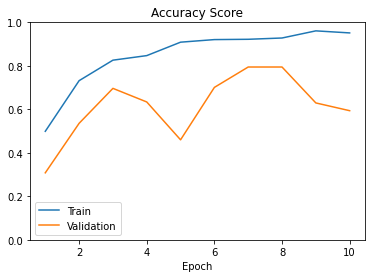

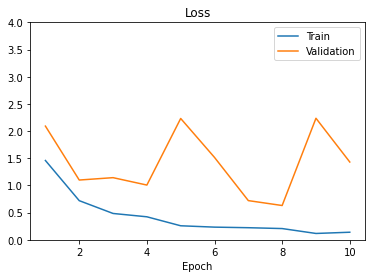

In [ ]:
import torchvision.models as models
import torch.optim as optim
from torch import nn
import torch
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from statistics import mean
from google.colab import output as colab_output


optimizer = optim.Adam(model.parameters(), lr=0.001)


loss_function = nn.CrossEntropyLoss()

n_epoch = 10
 


use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

train_accuracy = []
valid_accuracy = []

train_loss = []
valid_loss = []

n_batches = int(len(train_dataset) / batch_size)
print('Starting Train using device:{}'.format(device))

# append_dropout(model)
model.to(device)
for epoch in range(n_epoch):
  # 1. Train Phase
  model.train()
  train_batch_accuracy = []
  train_batch_loss = []
  for idx, (X,y) in enumerate(train_dl):
    X = X.to(device)
    y = y.to(device).view(-1,)
    optimizer.zero_grad()
    output = model(X)
    y_pred = torch.max(output,1)[1]
    train_batch_score = accuracy_score(y.cpu().data.squeeze().numpy(), y_pred.cpu().data.squeeze().numpy())
    train_batch_accuracy.append(train_batch_score)


    loss = loss_function(output,y)
    train_batch_loss.append(loss.item())

    loss.backward()
    optimizer.step()

  train_accuracy.append(mean(train_batch_accuracy))
  train_loss.append(mean(train_batch_loss))
    # print('Epoch:{} Batch:{}/{} Train Loss:{}  Train Accuracy:{}'.format(epoch,idx,n_batches,loss.item(),batch_score))
  # 2. Validation Phase
  model.eval()
  with torch.no_grad():
    Valid_batch_accuracy = []
    Valid_batch_loss = []
    for idx, (X,y) in enumerate(valid_dl):
      X = X.to(device)
      y = y.to(device).view(-1,)
      output = model(X)
      y_pred = torch.max(output,1)[1]

      
      # print(idx)
      # print(y)
      # print(y_pred)
      valid_batch_score = accuracy_score(y.cpu().data.squeeze().numpy(), y_pred.cpu().data.squeeze().numpy())
      Valid_batch_accuracy.append(valid_batch_score)

      loss = loss_function(output,y)
      Valid_batch_loss.append(loss.item())

    valid_accuracy.append(mean(Valid_batch_accuracy))
    valid_loss.append(mean(Valid_batch_loss))
  # 3. Showing Reports
  
  colab_output.clear()
  plt.plot(list(range(1,epoch+2)),train_accuracy)
  plt.plot(list(range(1,epoch+2)),valid_accuracy)

  plt.legend(['Train','Validation'])
  plt.title('Accuracy Score')
  plt.ylim([0,1])
  plt.xlabel('Epoch')
  plt.show()

  
  plt.plot(list(range(1,epoch+2)),train_loss)
  plt.plot(list(range(1,epoch+2)),valid_loss)

  plt.legend(['Train','Validation'])
  plt.title('Loss')
  plt.ylim([0,4])
  plt.xlabel('Epoch')
  plt.show()

In [ ]:
import math 
model.eval()
with torch.no_grad():
  Test_batch_accuracy = []
  for idx, (X,y) in enumerate(test_dl):
    X = X.to(device)
    y = y.to(device).view(-1,)
    output = model(X)
    y_pred = torch.max(output,1)[1]


    Test_batch_score = accuracy_score(y.cpu().data.squeeze().numpy(), y_pred.cpu().data.squeeze().numpy())
    Test_batch_accuracy.append(Test_batch_score)



  Test_accuracy = mean(Test_batch_accuracy)

print('Model accuracy on test data: {}%'.format(np.round(Test_accuracy * 100,3)))

Model accuracy on test data: 66.518%


In [ ]:
img_1 = X_test[24].to(device)
img_1.unsqueeze_(0)
output = model(img_1)
labels = torch.argmax(output, 1)
# output|


print(labels)
names

tensor([2], device='cuda:0')


['Jessica_Meir', 'Joseph_Acaba', 'Raja_Chari', 'Scott_Tingle']

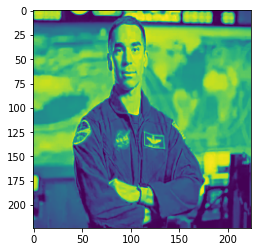

In [ ]:
import PIL
import torchvision.transforms as T

# X_test[1].shape

plt.imshow(X_test[24].numpy()[0])

In [ ]:
import cv2
from torchvision import datasets, transforms, models
url = '/content/images.jpeg'
img = cv2.imread(url)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# img.unsqueeze_(0)
test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

img = test_transform(img)
img.unsqueeze_(0)
output = model(img.to(device))

labels = torch.argmax(output, 1)
# # output|


print(labels)
names

tensor([3], device='cuda:0')


['Jessica_Meir', 'Joseph_Acaba', 'Raja_Chari', 'Scott_Tingle']

In [ ]:
torch.save(model, '/content/drive/MyDrive/Astro_trained_77%.pth')


In [ ]:
new_model = torch.load('/content/drive/MyDrive/Astro_trained_77%.pth')

In [ ]:
import cv2
from torchvision import datasets, transforms, models
url = '/content/images.jpeg'
img = cv2.imread(url)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# img.unsqueeze_(0)
test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

img = test_transform(img)
img.unsqueeze_(0)
output = new_model(img.to(device))

labels = torch.argmax(output, 1)
# # output|


print(labels)
names

tensor([3], device='cuda:0')


['Jessica_Meir', 'Joseph_Acaba', 'Raja_Chari', 'Scott_Tingle']